# RIBBIT Pulse Rate model demonstration
RIBBIT (Repeat-Interval Based Bioacoustic Identification Tool) is a tool for detecting vocalizations that have a repeating structure.

This tool is useful for detecting vocalizations of frogs, toads, and other animals that produce vocalizations with a periodic structure. In this notebook, we demonstrate how to select model parameters for the Great Plains Toad, then run the model on data to detect vocalizations.

This work is described in:

* 2021 paper, ["Automated detection of frog calls and choruses by pulse repetition rate"](https://doi.org/10.1111/cobi.13718)

* 2020 poster, ["Automatic Detection of Pulsed Vocalizations"](https://f1000research.com/posters/9-964)

RIBBIT is also [available as an R package](https://github.com/kitzeslab/r-ribbit).

This notebook demonstrates how to use the RIBBIT tool implemented in opensoundscape as `opensoundscape.ribbit.ribbit()`

For help instaling OpenSoundscape, see the [documentation](https://opensoundscape.org)

## Import packages

In [1]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')

#import packages
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import subprocess

#local imports from opensoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.ribbit import ribbit

# create big visuals
plt.rcParams['figure.figsize']=[15,8] 
pd.set_option('display.precision', 2)

## Download example audio

First, let's download some example audio to work with.

You can run the cell below, **OR** visit this link to downlaod the data (whichever you find easier):

https://pitt.box.com/shared/static/0xclmulc4gy0obewtzbzyfnsczwgr9we.zip

If you download using the link above, first un-zip the folder (double-click on mac or right-click -> extract all on Windows). Then, move the `great_plains_toad_dataset` folder to the same location on your computer as this notebook. Then you can skip this cell:

In [2]:
#download files from box.com to the current directory
subprocess.run(['curl', 'https://pitt.box.com/shared/static/211w13xunwfw0ucg9ft9fmjnaxl4uutt.gz','-L', '-o', 'great_plains_toad_dataset.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "great_plains_toad_dataset.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "great_plains_toad_dataset.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      6      0 --:--:--  0:00:01 --:--:--     0
100 11.6M  100 11.6M    0     0  5308k      0  0:00:02  0:00:02 --:--:-- 18.3M


CompletedProcess(args=['rm', 'great_plains_toad_dataset.tar.gz'], returncode=0)

now, you should have a folder in the same location as this notebook called `great_plains_toad_dataset`

if you had trouble accessing the data, you can try using your own audio files - just put them in a folder called `great_plains_toad_dataset` in the same location as this notebook, and this notebook will load whatever is in that folder

### Load an audio file and create a spectrogram

In [3]:
audio_path = np.sort(glob('./great_plains_toad_dataset/*'))[0]

#load the audio file into an OpenSoundscape Audio object
audio = Audio.from_file(audio_path)

#trim the audio to the time from 0-3 seconds for a closer look
audio = audio.trim(0,3)

#create a Spectrogram object
spectrogram = Spectrogram.from_audio(audio)

### Show the Great Plains Toad spectrogram as an image
A spectrogram is a visual representation of audio with frequency on the vertical axis, time on the horizontal axis, and intensity represented by the color of the pixels

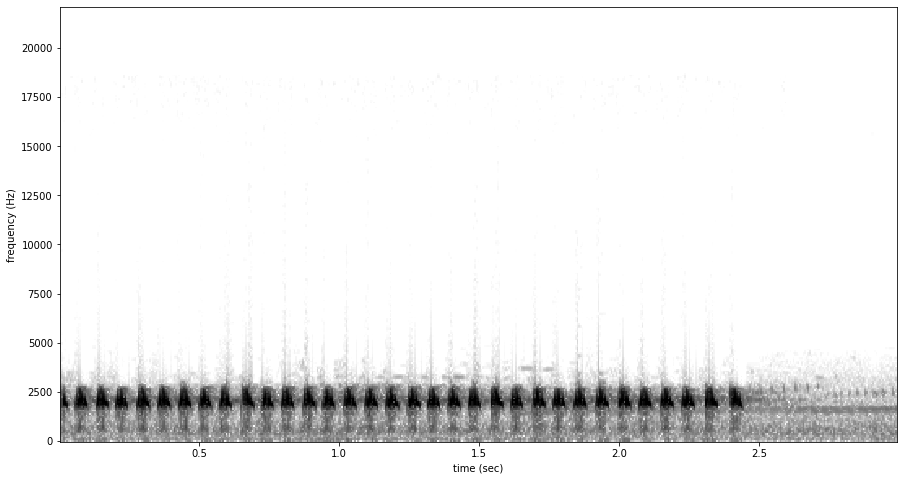

In [4]:
spectrogram.plot()

## Select model parameters

RIBBIT requires the user to select a set of parameters that describe the target vocalization. Here is some detailed advice on how to use these parameters.

**Signal Band:** The signal band is the frequency range where RIBBIT looks for the target species. Based on the spectrogram above, we can see that the Great Plains Toad vocalization has the strongest energy around 2000-2500 Hz, so we will specify `signal_band = [2000,2500]`. It is best to pick a narrow signal band if possible, so that the model focuses on a specific part of the spectrogram and has less potential to include erronious sounds. 

**Noise Bands:** Optionally, users can specify other frequency ranges called noise bands. Sounds in the `noise_bands` are _subtracted_ from the `signal_band`. Noise bands help the model filter out erronious sounds from the recordings, which could include confusion species, background noise, and popping/clicking of the microphone due to rain, wind, or digital errors. It's usually good to include one noise band for very low frequencies -- this specifically eliminates popping and clicking from being registered as a vocalization. It's also good to specify noise bands that target confusion species. Another approach is to specify two narrow `noise_bands` that are directly above and below the `signal_band`. 

**Pulse Rate Range:** This parameters specifies the minimum and maximum pulse rate (the number of pulses per second, also known as pulse repetition rate) RIBBIT should look for to find the focal species. Looking at the spectrogram above, we can see that the pulse rate of this Great Plains Toad vocalization is about 15 pulses per second. By looking at other vocalizations in different environmental conditions, we notice that the pulse rate can be as slow as 10 pulses per second or as fast as 20. So, we choose `pulse_rate_range = [10, 20]` meaning that RIBBIT should look for pulses no slower than 10 pulses per second and no faster than 20 pulses per second. 

**Clip Duration:** This parameter tells the algorithm how many seconds of audio to analyze at one time. Generally, you should choose a `clip_duration` that is ~2x longer than the target species vocalization, or a little bit longer. For very slowly pulsing vocalizations, choose a longer window so that at least 5 pulses can occur in one window (0.5 pulses per second -> 10 second window). Typical values for `clip_duration` are 0.3 to 10 seconds. Here, because the The Great Plains Toad has a vocalization that continues on for many seconds (or minutes!), we chose a 2-second window which will include plenty of pulses. 

- we can also set `clip_overlap` if we want overlapping clips. For instance, a `clip_duration` of 2 with `clip_overlap` of 1 results in 50% overlap of each consecutive clip. This can help avoid sounds being split up across two clips, and therefore not being detected. 
- `final_clip` determines what should be done when there is less than `clip_duration` audio remaining at the end of an audio file. We'll just use `final_clip=None` to discard any remaining audio that doesn't make a complete clip. 

**Plot:** We can choose to show the power spectrum of pulse repetition rate for each window by setting `plot=True`. The default is not to show these plots (`plot=False`).

In [5]:
# minimum and maximum rate of pulsing (pulses per second) to search for
pulse_rate_range = [8,15] 

# look for a vocalization in the range of 1000-2000 Hz 
signal_band = [1800,2400] 

# subtract the amplitude signal from these frequency ranges
noise_bands = [ [0,1000], [3000,3200] ] 

#divides the signal into segments this many seconds long, analyzes each independently
clip_duration = 2 #seconds
clip_overlap = 0 #seconds

#if True, it will show the power spectrum plot for each audio segment 
show_plots = True 

## Search for pulsing vocalizations with `ribbit()` 

This function takes the parameters we chose above as arguments, performs the analysis, and returns two arrays:
 - **scores:** the pulse rate score for each window
 - **times:** the start time in seconds of each window
 
The scores output by the function may be very low or very high. They do not represent a "confidence" or "probability" from 0 to 1. Instead, the relative values of scores on a set of files should be considered: when RIBBIT detects the target species, the scores will be significantly higher than when the species is not detected. 

#### Analyzing one file
The file `gpt0.wav` has a Great Plains Toad vocalizing only at the beginning. Let's analyze the file with RIBBIT and look at the scores versus time.

spectrogram of 10 second file with Great Plains Toad at the beginning


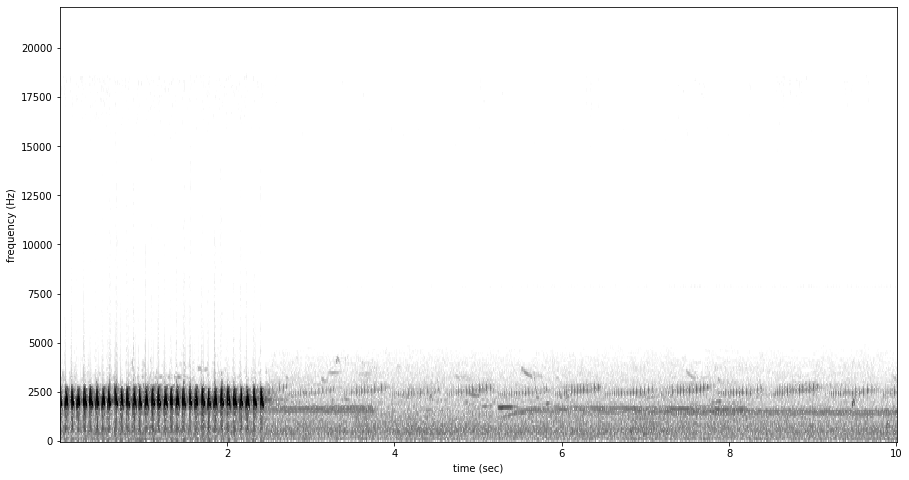

Text(0.5, 1.0, 'RIBBIT scores for 10 second file with Great Plains Toad at the beginning')

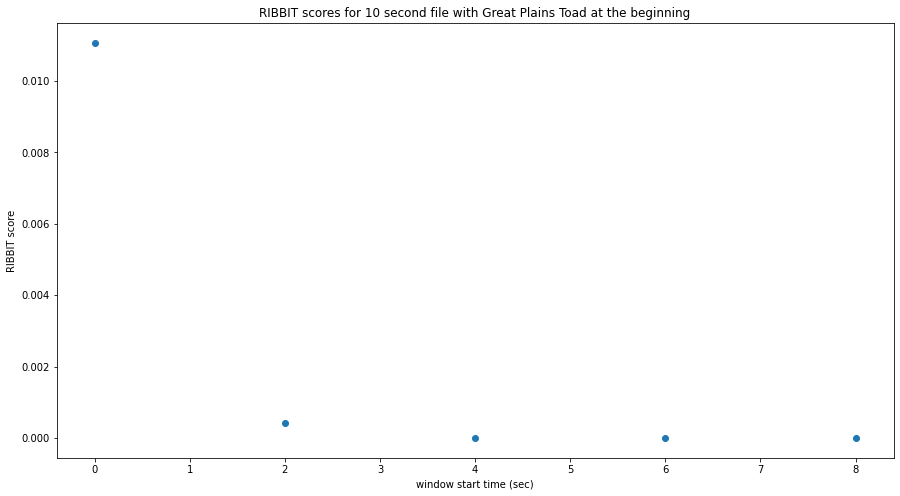

In [6]:
#get the audio file path
audio_path = np.sort(glob('./great_plains_toad_dataset/*'))[0]

#make the spectrogram
spec = Spectrogram.from_audio(audio.from_file(audio_path))

#run RIBBIT
score_df =  ribbit(
                    spec,
                    pulse_rate_range=pulse_rate_range,
                    signal_band=signal_band,
                    clip_duration=clip_duration,
                    noise_bands=noise_bands,
                    plot=False
)


#show the spectrogram
print('spectrogram of 10 second file with Great Plains Toad at the beginning')
spec.plot()

# plot the score vs time of each window
plt.scatter(score_df['start_time'],score_df['score'])
plt.xlabel('window start time (sec)')
plt.ylabel('RIBBIT score')
plt.title('RIBBIT scores for 10 second file with Great Plains Toad at the beginning')

as we hoped, RIBBIT outputs a high score during the vocalization (the window from 0-2 seconds) and a low score when the frog is not vocalizing

## Analyzing a set of files

In [7]:
# set up a dataframe for storing files' scores and labels
df = pd.DataFrame(index = glob('./great_plains_toad_dataset/*'),columns=['score','label'])

# label is 1 if the file contains a Great Plains Toad vocalization, and 0 if it does not
df['label'] = [1 if 'gpt' in f else 0 for f in df.index] 

# calculate RIBBIT scores
for path in df.index:
    
    #make the spectrogram
    spec = Spectrogram.from_audio(audio.from_file(path))

    #run RIBBIT
    score_df =  ribbit(
                        spec,
                        pulse_rate_range=[8,20],
                        signal_band=[1900,2400],
                        clip_duration=clip_duration,
                        noise_bands=[[0,1500],[2500,3500]],
                        plot=False)
    
    # use the maximum RIBBIT score from any window as the score for this file
    # multiply the score by 10,000 to make it easier to read
    df.at[path,'score'] = max(score_df['score']) * 10000

print("Files sorted by score, from highest to lowest:")
df.sort_values(by='score',ascending=False)

Files sorted by score, from highest to lowest:


,score,label
./great_plains_toad_dataset/gpt0.wav,107.65,1
./great_plains_toad_dataset/gpt3.wav,29.31,1
./great_plains_toad_dataset/gpt2.wav,16.69,1
./great_plains_toad_dataset/gpt1.wav,10.13,1
./great_plains_toad_dataset/negative9.wav,3.04,0
./great_plains_toad_dataset/negative8.wav,0.89,0
./great_plains_toad_dataset/negative4.wav,0.76,0
./great_plains_toad_dataset/negative2.wav,0.65,0
./great_plains_toad_dataset/negative1.wav,0.3,0
./great_plains_toad_dataset/negative3.wav,0.3,0


So, how good is RIBBIT at finding the Great Plains Toad?

We can see that the scores for all of the files with Great Plains Toad (gpt) score above 10 except `gpt4.wav` (which contains only a very quiet and distant vocalization). All files that do not contain the Great Plains Toad score less than 3.5. So, RIBBIT is doing a good job separating Great Plains Toads vocalizations from other sounds! 

Notably, noisy files like `pops1.wav` score low even though they have lots of periodic energy - our `noise_bands` sucessfully rejected these files. Without using `noise_bands`, files like these would receive very high scores. Also, some birds in "negatives" files  that have periodic calls around the same pulse rate as the Great Plains Toad received low scores. This is also a result of choosing a tight `signal_band` and strategic `noise_bands`. You can try adjusting or eliminating these bands to see their effect on the audio. 

(HINT: eliminating the `noise_bands` will result in high scores for the "pops" files)

## Run RIBBIT on multiple species simultaneously

If you want to search for multiple species, its best to combine the analysis into one function - that way you only have to load each audio file (and make it's spectrogram) one time, instead of once for each species. (If you have thousands of audio files, this might be a big time saver.) 

This code gives a quick exmaple of how you could use a pre-made dataframe (could load it in from a spreadsheet, for instance) of parameters for a set of species to run RIBBIT on all of them.

Note that this example assumes you are using the same spectrogram settings for each species - this might not be the case in practice, if some species require high time-resolution spectrograms and others require high frequency-resolution spectrograms. 

In [8]:
#we'll create a dataframe here, but you could also load it from a spreadsheet
species_df = pd.DataFrame(columns=['pulse_rate_range','signal_band','clip_duration','noise_bands'])

species_df.loc['great_plains_toad']={
    'pulse_rate_range':[8,20],
    'signal_band':[1900,2400],
    'clip_duration':2.0,
    'noise_bands':[[0,1500],[2500,3500]]
}

species_df.loc['bird_series']={
    'pulse_rate_range':[8,11],
    'signal_band':[5000,6500],
    'clip_duration':2.0,
    'noise_bands':[[0,4000]]
}


species_df

,pulse_rate_range,signal_band,clip_duration,noise_bands
great_plains_toad,"[8, 20]","[1900, 2400]",2.0,"[[0, 1500], [2500, 3500]]"
bird_series,"[8, 11]","[5000, 6500]",2.0,"[[0, 4000]]"


now let's analyze each audio file for each species. 

We'll save the results in a table that has a column for each species. 

In [9]:
# set up a dataframe for storing files' scores and labels
df = pd.DataFrame(index = glob('./great_plains_toad_dataset/*'),columns=species_df.index.values)

# calculate RIBBIT scores
for path in df.index:
    
    for species, species_params in species_df.iterrows():
    #use RIBBIT for each species in species_df 
        #make the spectrogram
        spec = Spectrogram.from_audio(audio.from_file(path))

        #run RIBBIT
        score_df =  ribbit(
                            spec,
                            pulse_rate_range=species_params['pulse_rate_range'],
                            signal_band=species_params['signal_band'],
                            clip_duration=species_params['clip_duration'],
                            noise_bands=species_params['noise_bands'],
                            plot=False)

        # use the maximum RIBBIT score from any window as the score for this file
        # multiply the score by 10,000 to make it easier to read
        df.at[path,species] = max(score_df['score']) * 10000

print("Files with scores for each species, sorted by 'bird_series' score:")
df.sort_values(by='bird_series',ascending=False)

Files with scores for each species, sorted by 'bird_series' score:


,great_plains_toad,bird_series
./great_plains_toad_dataset/negative5.wav,0.0,93.81
./great_plains_toad_dataset/negative1.wav,0.3,72.63
./great_plains_toad_dataset/negative3.wav,0.3,5.05
./great_plains_toad_dataset/negative7.wav,0.0,2.87
./great_plains_toad_dataset/negative9.wav,3.04,0.09
./great_plains_toad_dataset/negative2.wav,0.65,0.02
./great_plains_toad_dataset/negative6.wav,0.06,0.01
./great_plains_toad_dataset/pops2.wav,0.0,0.01
./great_plains_toad_dataset/negative8.wav,0.89,0.0
./great_plains_toad_dataset/negative4.wav,0.76,0.0


looking at the highest scoring file for 'bird_series', it has the trilled bird sound at 5-6.5 kHz

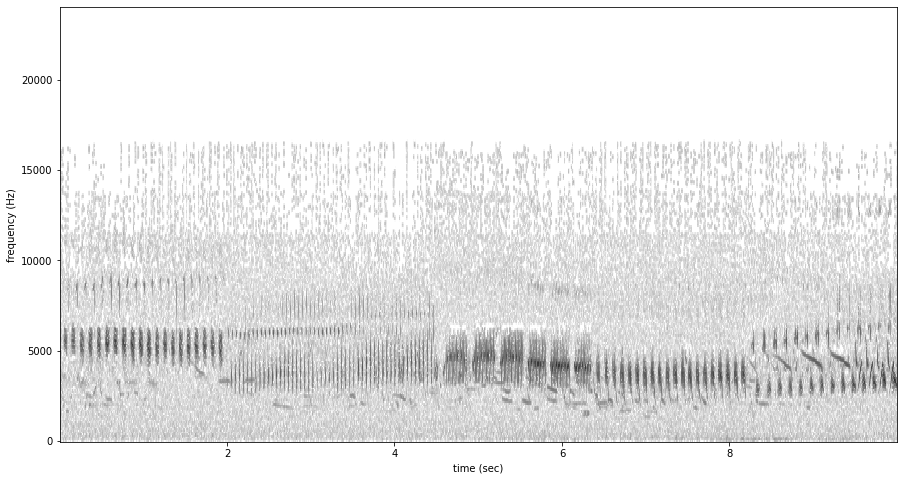

In [10]:
Spectrogram.from_audio(audio.from_file('./great_plains_toad_dataset/negative5.wav')).plot()

### Warning
when loading a dataframe from a file, lists of numbers like [8,20] might be read in as strings ("[8,20]") rather than a list of numbers. 
Here's a handy little piece of code that will load the values in the desired format

In [11]:
#let's say we have the species df saved as a csv file
species_df.index.name='species'
species_df.to_csv('species_df.csv')

#define the conversion parameters for each column
import ast
generic = lambda x: ast.literal_eval(x)
conv = {
    'pulse_rate_range':generic,
    'signal_band':generic,
    'noise_bands':generic
}
#tell pandas to use them when loading the csv
species_df=pd.read_csv('./species_df.csv',converters=conv).set_index('species')

#now the species_df has numeric values instead of strings
species_df

,pulse_rate_range,signal_band,clip_duration,noise_bands
species,,,,
great_plains_toad,"[8, 20]","[1900, 2400]",2.0,"[[0, 1500], [2500, 3500]]"
bird_series,"[8, 11]","[5000, 6500]",2.0,"[[0, 4000]]"


## Detail view of RIBBIT method
Now, let's look at one 10 second file and tell ribbit to plot the power spectral density for each window (`plot=True`). This way, we can see if peaks are emerging at the expected pulse rates. Since our `window_length` is 2 seconds, each of these plots represents 2 seconds of audio. The vertical lines on the power spectral density represent the lower and upper `pulse_rate_range` limits. 

In the file `gpt0.wav`, the Great Plains Toad vocalizes for a couple seconds at the beginning, then stops. We expect to see a peak in the power spectral density at 15 pulses/sec in the first 2 second window, and maybe a bit in the second, but not later in the audio. 

window: 0.0 to 2.0 sec


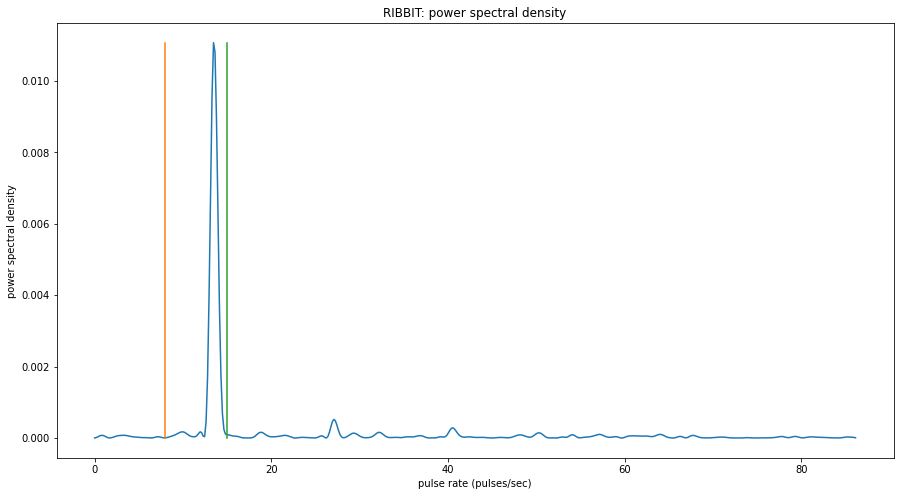

window: 2.0 to 4.0 sec


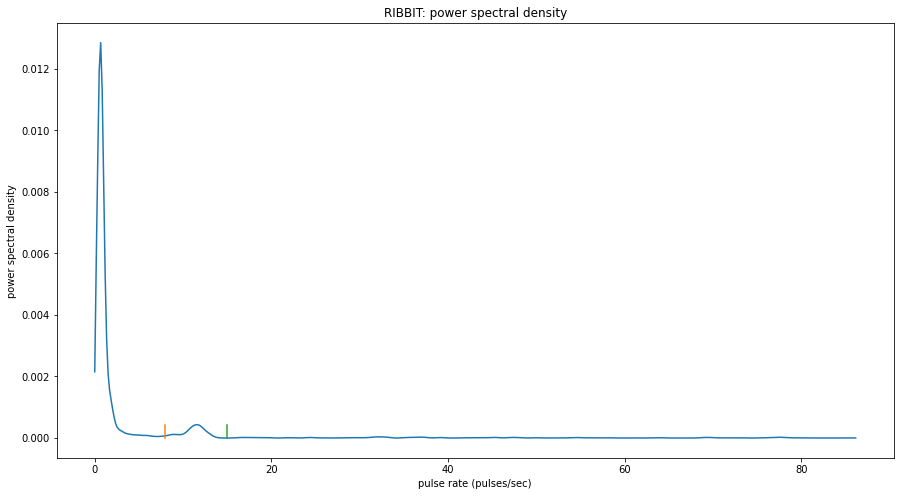

window: 4.0 to 6.0 sec


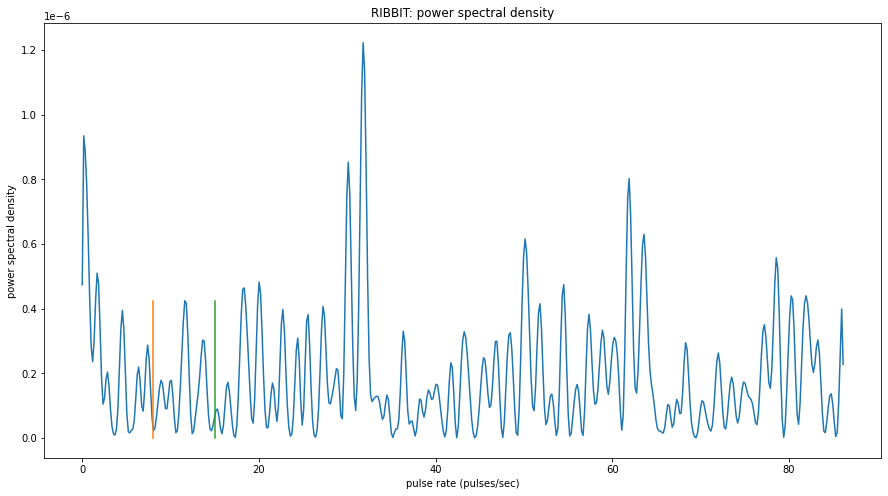

window: 6.0 to 8.0 sec


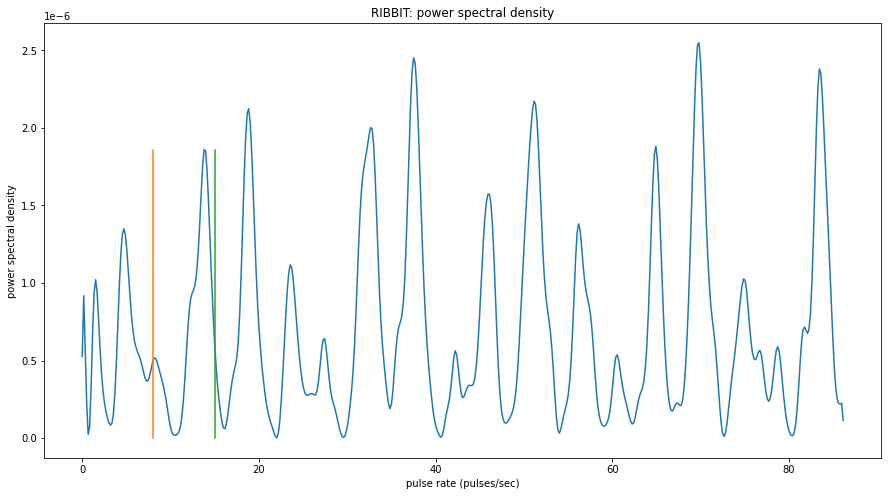

In [12]:
#create a spectrogram from the file, like above:
# 1. get audio file path
audio_path = np.sort(glob('./great_plains_toad_dataset/*'))[0]
# 2. make audio object and trim (this time 0-10 seconds)
audio = Audio.from_file(audio_path).trim(0,10)
# 3. make spectrogram
spectrogram = Spectrogram.from_audio(audio)

clip_df =  ribbit(
                        spectrogram,
                        pulse_rate_range=pulse_rate_range,
                        signal_band=signal_band,
                        clip_duration=clip_duration,
                        noise_bands=noise_bands,
                        plot=show_plots)


## Time to experiment for yourself

Now that you know the basics of how to use RIBBIT, you can try using it on your own data. We recommend spending some time looking at different recordings of your focal species before choosing parameters. Experiment with the noise bands and window length, and get in touch if you have questions!

Sam's email: sam . lapp [at] pitt.edu

#### Clean up
this cell will delete the folder `great_plains_toad_dataset`. Only run it if you wish delete that folder and the example audio inside it. 

In [13]:
from pathlib import Path
import shutil
shutil.rmtree('./great_plains_toad_dataset/')
Path('./species_df.csv').unlink()